# Bayesian inference for state-space models 

## Defining a prior distribution 

We have already seen that module `pysqmc.distributions` defines various `ProbDist` objects; i.e. objects that represent probability distribution. Such objects have methods to simulate random variates, compute the log-density, and so on.

This module defines in particular a class called `StructDist`, whose methods take as inputs and outputs  [structured arrays](https://docs.scipy.org/doc/numpy/user/basics.rec.html). This is what we are going to use to define prior distributions. Here is a simple example:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from pysqmc import distributions as dists

prior_dict = {'mu': dists.Normal(scale=2.), 'rho': dists.Uniform(a=-1., b=1.), 'sigma':dists.Gamma()}
my_prior = dists.StructDist(prior_dict)

Object `my_prior` represents a distribution for $\theta=(\mu, \rho, \sigma)$ where $\mu\sim N(0,2^2)$, $\rho \sim \mathcal{U}([-1,1])$, $\sigma \sim \mathrm{Gamma}(1, 1)$, independently. We may now sample from this distribution, or compute its pdf, and so on. For each of the operations, the inputs and outputs must be structured arrays, with named variables `'rho'` and `'sigma'`.

Text(0.5, 0, 'log-pdf')

/home/manxac/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/manxac/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


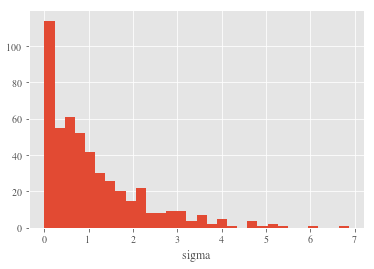

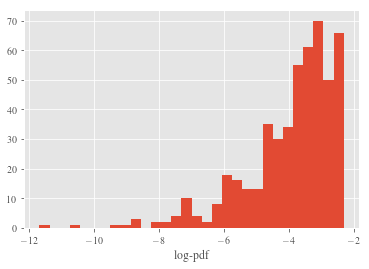

In [2]:
theta = my_prior.rvs(size=500)  # sample 500 theta-parameters

plt.style.use('ggplot')
plt.hist(theta['sigma'], 30);
plt.xlabel('sigma')

plt.figure()
z = my_prior.logpdf(theta) 
plt.hist(z, 30)
plt.xlabel('log-pdf')

We may want to transform `sigma` into its logarithm, so that the support of the distribution is not constrained to $\mathbb{R}^+$:

Text(0.5, 0, 'log-sigma')

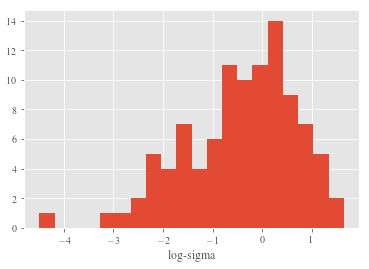

In [3]:
another_prior_dict = {'rho': dists.Uniform(a=-1., b=1.), 'log_sigma':dists.LogD(dists.Gamma())}
another_prior = dists.StructDist(another_prior_dict)
another_theta = another_prior.rvs(size=100)

plt.hist(another_theta['log_sigma'], 20)
plt.xlabel('log-sigma')

Now, `another_theta` contains two variables, `rho` and `log_sigma`, and the latter variable is distributed according to $Y=\log(X)$, with $X\sim \mathrm{Gamma}(1, 1)$. (The documention of module `distributions` as more details on tranformed distributions.)

We may also want to introduce dependencies between $\rho$ and $\sigma$. Consider this:

Text(0, 0.5, 'sigma')

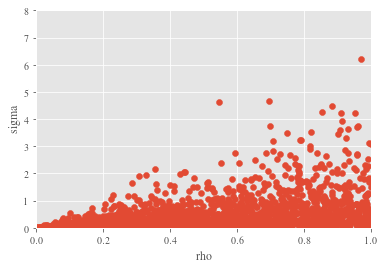

In [4]:
from collections import OrderedDict

dep_prior_dict = OrderedDict()
dep_prior_dict['rho'] = dists.Uniform(a=0., b=1.)
dep_prior_dict['sigma'] = dists.Cond( lambda theta: dists.Gamma(b=1./theta['rho']))
dep_prior = dists.StructDist(dep_prior_dict)
dep_theta = dep_prior.rvs(size=2000)

plt.scatter(dep_theta['rho'], dep_theta['sigma'])
plt.axis([0., 1., 0., 8.])
plt.xlabel('rho')
plt.ylabel('sigma')

The lines above encodes a **chain rule** decomposition: first we specify the marginal distribution of $\rho$, thne we specify the distribution of $\sigma$ given $\rho$. A standard dictionary in Python is unordered: there is no way to make sure that the keys appear in a certain order. Thus we use instead an `OrderedDict`, and define first the distribution of $\rho$, then the distribution of $\sigma$ given $\rho$; `Cond` is a particular `ProbDist` class that defines a conditional distribution, based on a function that takes an argument `theta`, and returns a `ProbDist` object.

All the example above involve univariate distributions; however, the components of `StructDist` also ccept multivariate distributions. 

In [5]:
reg_prior_dict = OrderedDict()
reg_prior_dict['sigma2'] = dists.InvGamma(a=2., b=3.)
reg_prior_dict['beta'] = dists.MvNormal(cov=np.eye(20))
reg_prior = dists.StructDist(reg_prior_dict)
reg_theta = reg_prior.rvs(size=200)

## Bayesian inference for state-space models

We return to the simplified stochastic volatility introduced in the basic tutorial: 

\begin{align*}
X_0 & \sim N\left(\mu, \frac{\sigma^2}{1-\rho^2}\right) \\
X_t|X_{t-1}=x_{t-1} & \sim N\left( \mu + \rho (x_{t-1}-\mu), \sigma^2\right) \\
Y_t|X_t=x_t & \sim N\left(0, e^{x_t}\right)
\end{align*}

which we implemented as follows (this time with default values for the parameters):

In [6]:
from pysqmc import state_space_models as ssm

class StochVol(ssm.StateSpaceModel):
    default_parameters = {'mu':-1., 'rho':0.95, 'sigma': 0.2}
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))

We mentioned in the basic tutorial that `StochVol` represents the parameteric class of univariate stochastic volatility model. Indeed, `StochVol` will be the object we pass to Bayesian inference algorithms (such as PMMH or SMC$^2$) in order to perform inference with respect to that class of models. 

## PMMH (Particle marginal Metropolis-Hastings)

Let's try first PMMH. This is a Metropolis-Hastings algorithm that samples from the posterior of parameter $\theta$ (given the data). However, since the corresponding likelihood is intractable, each iteration of PMMH run a particle filter that approximates it.

In [7]:
from pysqmc import mcmc

# real data
raw_data = np.loadtxt('../../../datasets/GBP_vs_USD_9798.txt', skiprows=2, usecols=(3,), comments='(C)')
full_data = np.diff(np.log(raw_data))
data = full_data[:50]

my_pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=data, Nx=200, 
                    niter=1000)
my_pmmh.run();  # may take several seconds...

The arguments we set when instantiating class `PMMH` requires little explanation; just in case:
  * `Nx` is the number of particles (for the particle filter run at each    iteration);
  * `niter` is the number of MCMC iterations. 
  
Upon completion, object `my_pmmh.chain` is a `ThetaParticles` object, with the following attributes:
  * `my_pmmh.chain.theta` is a structured array of size 10 (the number of iterations) with keys ``'mu'``, ``'rho'`` and ``'sigma'``; 
  * `my_pmmh.chain.lpost` is an array of length 10, contanining the (estimated) log-posterior density for each simulated $\theta$.
  
Let's plot the mcmc traces. 

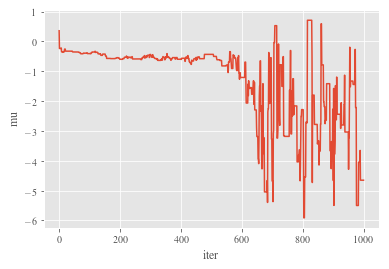

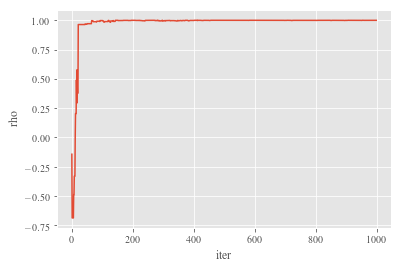

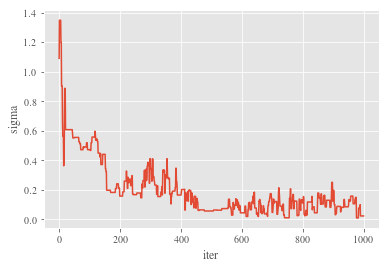

In [8]:
for p in prior_dict.keys():  # loop over mu, theta, rho
    plt.figure()
    plt.plot(my_pmmh.chain.theta[p]) 
    plt.xlabel('iter')
    plt.ylabel(p)

You might wonder what type of Metropolis sampler is really implemented here: 
  * the starting point of the chain is sampled from the prior; you may instead set it to a specific value using option `starting_point` (when instantiating `PMMH`); 
  * the proposal is an **adaptative** Gaussian random walk: this means that the covariance matrix of the random step is calibrated on the fly on past simulations (using vanishing adaptation). This may be disabled by setting option `adaptive=False`; 
  * a bootstrap filter is run to approximate the log-likelihood; you may use a different filter (e.g. a guided filter) by passing a `FeynmanKac` class to option `fk_cls`;
  * you may also want to pass various parameters to each call to ` SMC` through (dict) argument `smc_options`; e.g. `smc_options={'qmc': True}` will make each particle filter a SQMC algorithm. 
  
Thus, by and large, quite a lot of flexibilty is hidden behind this default behaviour.

## Particle Gibbs
PMMH is just a particular instance of the general family of PMCMC samplers; that is MCMC samplers that run some of particle filtering at each iteration. Another instance is Particle Gibbs (PG), where one simulate alternatively: 
1. from the distribution of $\theta$ given the states and the data; 
2. renew the state trajectory through a CSMC (conditional SMC step). 

Since Step 1 is model- (and user-)dependent, you need to define it for the model you are considering. This is done by sub-classing `ParticleGibbs` and defining method `update_theta` as follows:

In [9]:
class PGStochVol(mcmc.ParticleGibbs):
    def update_theta(self, theta, x):
        new_theta = theta.copy()
        sigma, rho = 0.2, 0.95  # fixed values
        xlag = np.array(x[1:] + [0.,])
        dx = (x - rho * xlag) / (1. - rho)
        s = sigma / (1. - rho)**2
        new_theta['mu'] = self.prior.laws['mu'].posterior(dx, sigma=s).rvs() 
        return new_theta

For simplicity $\rho$ and $\sigma$ are kept constant; only $\mu$ is updated. This means we are actually sampling from the posterior of $\mu$ given the data, while these other parameters are kept contant. Let's run our PG algorithm:

In [10]:
pg = PGStochVol(ssm_cls=StochVol, data=data, prior=my_prior, Nx=200, niter=1000)
pg.run()  # may take several seconds...

Now let's plot the results:

Text(0.5, 0, 'mu')

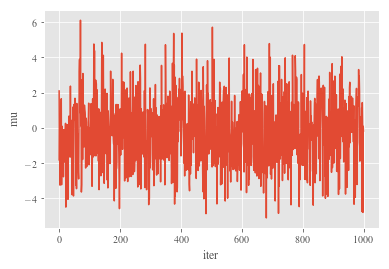

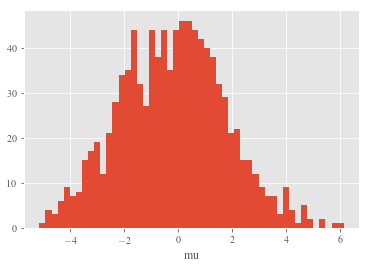

In [11]:
plt.plot(pg.chain.theta['mu']) 
plt.xlabel('iter')
plt.ylabel('mu')

plt.figure()
plt.hist(pg.chain.theta['mu'][20:], 50)
plt.xlabel('mu')

## SMC^2
Finally, we consider SMC$^2$, a SMC algorithm that makes it possible to approximate:
 * all the partial posteriors (of $\theta$ given $y_{0:t}$, for $t=0, 1, ..., T$) rather than only the final posterior; 
 * the marginal likelihoods of the data. 
 
 SMC$^2$ is a two-level SMC sampler: 
 1. it simulates many $\theta$-values from the prior, and update their weights recursisvely, according to the likelihood of each new datapoint; 
 2. however, since these likelihood factors are intractable, for each $\theta$, a particle filter is run to approximate it; hence $x$-particles are run for each $\theta$. 
 
 The class `SMC2` is defined inside module `smc_samplers`. It is run in the same way as the other SMC algorithms. 

In [12]:
import pysqmc
from pysqmc import smc_samplers as ssp

fk_smc2 = ssp.SMC2(ssm_cls=StochVol, data=data, prior=my_prior,init_Nx=50, 
                ar_to_increase_Nx=0.1)
alg_smc2 = pysqmc.SMC(fk=fk_smc2, N=500)
alg_smc2.run()

/home/manxac/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/manxac/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/manxac/miniconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:86: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC


Again, a few choices are made for you by default: 
* A bootstrap filter is run for each $\theta-$particle; this may be changed by setting option `fk_class` while instantiating `SMC2`; e.g. ``fk_class=ssm.GuidedPF`` will run instead a guided filter. 
* Option `init_Nx` determines the **initial** number of $x-$particles; the algorithm automatically increases $N_x$ each time the acceptance rate drops below $10%$ (as specified through option ``ar_to_increase=0.1``. Set this this option to 0 if you do not want to increase $N_x$ in the course of t he algorithm.
* The particle filters (in the $x-$dimension) are run with the default options of class `SMC`; e.g. resampling is set to `systematic` and so on; other options may be set by using option `smc_options`.

Text(0, 0.5, 'rho')

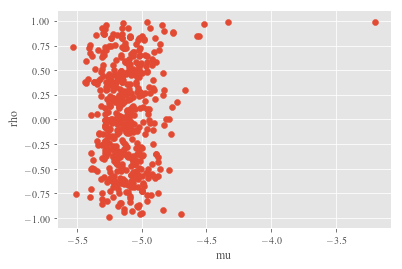

In [13]:
plt.scatter(alg_smc2.X.theta['mu'], alg_smc2.X.theta['rho'])
plt.xlabel('mu')
plt.ylabel('rho')